# Notebook 05: Volatility Forecasting

**Objective:**  
- Generate one-step-ahead volatility forecasts using GARCH  
- Compare GARCH forecasts with rolling historical volatility  
- Illustrate differences between forward-looking and backward-looking risk measures  

**Asset:** NIFTY 50 Index  
**Frequency:** Daily  

In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 15.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from arch import arch_model

In [4]:
ticker = "^NSEI"

df = yf.download(
    ticker,
    start="2015-01-01",
    end="2024-12-31",
    progress=False
)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df[["Close"]].rename(columns={"Close": "Price"})
df["log_return"] = np.log(df["Price"] / df["Price"].shift(1))
returns = df["log_return"].dropna()

# Scale returns (best practice)
returns_scaled = 100 * returns


/tmp/ipython-input-350081886.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


In [7]:
garch_11 = arch_model(
    returns_scaled,
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)

garch_res = garch_11.fit(disp="off")
print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3192.39
Distribution:                  Normal   AIC:                           6392.78
Method:            Maximum Likelihood   BIC:                           6416.01
                                        No. Observations:                 2457
Date:                Sun, Dec 21 2025   Df Residuals:                     2456
Time:                        07:54:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  1.759e-02      4.101  4.107e-05 [3.766e-0

In [9]:
# Conditional volatility (in-sample)
garch_vol = garch_res.conditional_volatility

# Convert back to return scale
garch_vol = garch_vol / 100
garch_vol

,cond_vol
Date,
2015-01-05,0.011512
2015-01-06,0.010859
2015-01-07,0.014531
2015-01-08,0.013652
2015-01-09,0.013778
...,...
2024-12-23,0.009850
2024-12-24,0.009532
2024-12-26,0.009031


In [10]:
rolling_vol = returns.rolling(window=30).std()

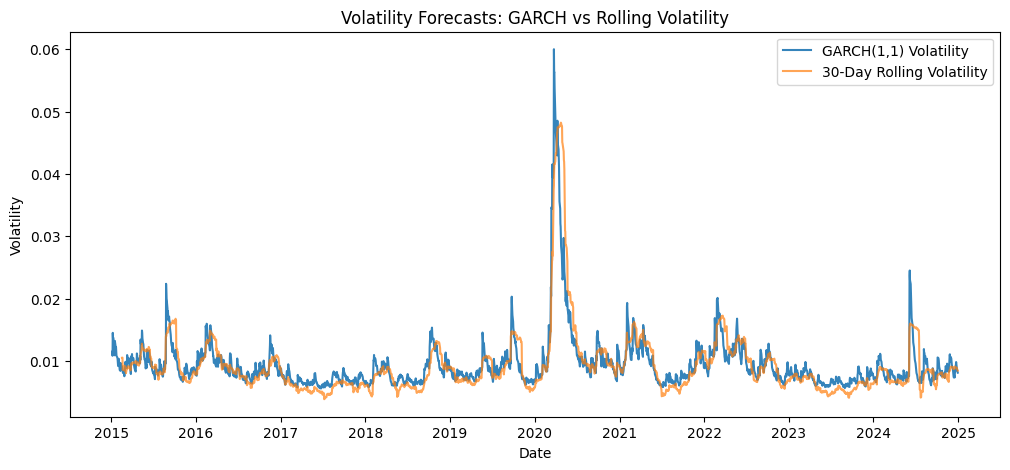

In [11]:
plt.figure(figsize=(12,5))
plt.plot(garch_vol, label="GARCH(1,1) Volatility", alpha=0.9)
plt.plot(rolling_vol, label="30-Day Rolling Volatility", alpha=0.7)
plt.title("Volatility Forecasts: GARCH vs Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()


### Interpretation

GARCH-based volatility forecasts respond more rapidly to market shocks compared
to rolling historical volatility. While rolling volatility reacts with a lag due
to its backward-looking nature, GARCH incorporates new information immediately
through its conditional variance dynamics. This highlights the advantage of
model-based, forward-looking volatility forecasts for risk management.

In [22]:
realized_var = returns**2

In [29]:
validation_df = pd.DataFrame({
    "RealizedVar": returns**2,
    "GARCH_Var": garch_vol**2,
    "Rolling_Var": rolling_vol**2
}).dropna()

validation_df.head()



,RealizedVar,GARCH_Var,Rolling_Var
Date,,,
2015-02-16,1.910449e-07,0.000084,0.000111
2015-02-18,4.569312e-05,0.000076,0.000112
2015-02-19,8.700989e-06,0.000072,0.000074
2015-02-20,4.844768e-05,0.000066,0.000076
2015-02-23,7.998282e-05,0.000066,0.000074


In [27]:
def mse(actual, forecast):
    return np.mean((actual - forecast)**2)

def mae(actual, forecast):
    return np.mean(np.abs(actual - forecast))


In [30]:
results = pd.DataFrame({
    "Model": ["GARCH(1,1)", "Rolling 30-Day"],
    "MSE": [
        mse(validation_df["RealizedVar"], validation_df["GARCH_Var"]),
        mse(validation_df["RealizedVar"], validation_df["Rolling_Var"])
    ],
    "MAE": [
        mae(validation_df["RealizedVar"], validation_df["GARCH_Var"]),
        mae(validation_df["RealizedVar"], validation_df["Rolling_Var"])
    ]
})

results

,Model,MSE,MAE
0,"GARCH(1,1)",2.338156e-07,0.000117
1,Rolling 30-Day,2.509460e-07,0.000121


### Interpretation

Volatility forecasts from the GARCH(1,1) model exhibit lower forecast errors
(MSE and MAE) compared to rolling historical volatility. This indicates that
model-based, forward-looking volatility estimates provide superior risk forecasts
relative to backward-looking historical measures.
